# Graph Analysis
### PageRank
**PageRank** is a **link analysis** algorithm, whcih assigns a numerical value (called rank) to each element of a hyperlinked set of documents, such as the World Wide Web (also called **webgraph**). Specifically, **PageRank** measures a node (page)'s importance based on both the quantity and quality of incoming links. 
- A page is important if important pages link to it, with importance divided among their outgoing links.

PageRank models a **random surfer** which:
- follows links (85% of time) 
- or jumps randomly (called teleportation) (15% of time). 

This random surfing solves two problems:
- Dangling nodes: Pages with no outgoing links.
- Disconnected components: Isolated parts of the web.

PageRank algorithm at first gives uniform rank to all pages $r_j=\frac{1}{n}$ where $n$ is the number of nodes (pages) of webgraph. Then it updates ranks $r_i$ by:
<br>$\large r_i=\frac{1-d}{n}+d\cdot (\sum_{j\rightarrow i, \;and\; j\notin D}\frac{r_j}{k^{out}_j}+\frac{1}{n}\sum_{j\in D}r_j)$
<br>Where:
- $D$  = set of dangling nodes (i.e., nodes $j$  with out-degree $k^{out}_j=0$ ).
- $r_j$  = PageRank of node $j$. 
- $d$ is a scalar called the **damping factor**, usually set to $0.85$.
- $j\rightarrow i$ means there ia a directed edge from node $j$ to node $i$.

<hr>

In the following:
- We first give the PageRank algorithm from scratch. 
- Then, we test it with a few directed graphs.
- Finally, we display the graphs by **NetworkX**

https://github.com/ostad-ai/Graph-Analysis
<br>Explanation in English :https://www.pinterest.com/HamedShahHosseini/graph-analysis/

In [1]:
# Import required modules
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def pagerank(adj_list,d=0.85,max_iter=100,tol=1e-6,
    personalization=None):
    """
    Compute PageRank from an adjacency list (directed graph).
    
    Parameters:
        adj_list (dict): {node: [outgoing_neighbors]}
        d (float): damping factor (default 0.85)
        max_iter (int): max iterations
        tol (float): convergence tolerance (L1 norm)
        personalization (dict): {node: prob} for biased teleportation (optional)
        
    Returns:
        dict: {node: PageRank_score}
    """
    nodes = list(adj_list.keys())
    n = len(nodes)
    if n == 0:
        return {}
    
    idx = {node: i for i, node in enumerate(nodes)}
    
    # Build out-degree and identify dangling nodes
    out_degree = {}
    dangling_nodes = []
    for node in nodes:
        neighbors = adj_list[node]
        deg = len(neighbors)
        out_degree[node] = deg
        if deg == 0:
            dangling_nodes.append(node)
    
    # Initialize PageRank
    if personalization is None:
        r = np.ones(n) / n
        teleport = np.ones(n) / n
    else:
        # Normalize personalization vector
        total = sum(personalization.get(node, 0) for node in nodes)
        if total == 0:
            teleport = np.ones(n) / n
        else:
            teleport = np.array([personalization.get(node, 0) / total for node in nodes])
        r = teleport.copy()
    
    for _ in range(max_iter):
        r_old = r.copy()
        r = np.zeros(n)
        
        # Contribution from non-dangling nodes
        for node in nodes:
            if out_degree[node] > 0:
                rank_per_link = r_old[idx[node]] / out_degree[node]
                for nb in adj_list[node]:
                    if nb in idx:  # only consider nodes in the graph
                        r[idx[nb]] += rank_per_link
        
        # Contribution from dangling nodes
        dangling_sum = sum(r_old[idx[node]] for node in dangling_nodes)
        r += (dangling_sum / n)
        
        # Add teleportation
        r = d * r + (1 - d) * teleport
        
        # Check convergence (L1 norm)
        if np.sum(np.abs(r - r_old)) < tol:
            break
    
    return {node: float(r[idx[node]]) for node in nodes}

In [3]:
# -------------------------------
# Example 1: Simple directed graph
# -------------------------------
adj_simple = {
    'A': ['B', 'C'],
    'B': ['C'],
    'C': ['A'],
    'D': ['C']  # D is a "voter" but no one links to D
}

pr = pagerank(adj_simple, d=0.85)
print("PageRank Scores:")
for node,score in sorted(pr.items(), key=lambda x: x[1], reverse=True):
    print(f"Node {node}: {score:.4f}")

PageRank Scores:
Node C: 0.3941
Node A: 0.3725
Node B: 0.1958
Node D: 0.0375


In [4]:
# -------------------------------
# Example 2: Star graph (directed out from center)
# -------------------------------
star_out = {
    0: [1, 2, 3, 4],  # center points to leaves
    1: [],
    2: [],
    3: [],
    4: []
}
pr_star = pagerank(star_out, d=0.85)
print("Star Graph (center → leaves):")
for node,score in sorted(pr_star.items(), key=lambda x: x[1], reverse=True):
    print(f"Node {node}: {score:.4f}")

Star Graph (center → leaves):
Node 1: 0.2073
Node 2: 0.2073
Node 3: 0.2073
Node 4: 0.2073
Node 0: 0.1709


In [5]:
# -------------------------------
# Example 3: Rank sink
# -------------------------------
# Two pages that only link to each other - creates a rank sink
rank_sink = {
    'A': ['B'],
    'B': ['A']
}

print("Rank Sink Example:")
pr_sink = pagerank(rank_sink)
for page, score in sorted(pr_sink.items(), key=lambda x: x[1], reverse=True):
    print(f"  {page}: {score:.4f}")

Rank Sink Example:
  A: 0.5000
  B: 0.5000


In [6]:
# -------------------------------
# Example 4: Dangling node
# -------------------------------
# Page C has no outgoing links (dangling node)
dangling_example = {
    'A': ['B', 'C'],
    'B': ['C'],
    'C': []  # Dangling node - no outgoing links
}

print("Dangling Node Example:")
pr_dangling = pagerank(dangling_example)
for page, score in sorted(pr_dangling.items(), key=lambda x: x[1], reverse=True):
    print(f"  {page}: {score:.4f}")

Dangling Node Example:
  C: 0.5209
  B: 0.2816
  A: 0.1976


In [7]:
# -------------------------------
# Example 5: Hubs and authorities
# -------------------------------
# Some pages are authorities (many incoming links)
# Some pages are hubs (many outgoing links)
web_structure = {
    'Hub1': ['Auth1', 'Auth2', 'Auth3'],
    'Hub2': ['Auth1', 'Auth4'],
    'Auth1': [],
    'Auth2': [],
    'Auth3': [],
    'Auth4': []
}

print("Hub vs Authority Structure:")
pr_web = pagerank(web_structure)
for page, score in sorted(pr_web.items(), key=lambda x: x[1], reverse=True):
    node_type = "Hub" if page.startswith('Hub') else "Authority"
    print(f"  {page} ({node_type}): {score:.4f}")

Hub vs Authority Structure:
  Auth1 (Authority): 0.2219
  Auth4 (Authority): 0.1851
  Auth2 (Authority): 0.1667
  Auth3 (Authority): 0.1667
  Hub1 (Hub): 0.1299
  Hub2 (Hub): 0.1299


In [8]:
# -------------------------------
# Example 6: PageRank specialization
# -------------------------------
"""Personalized PageRank - teleport to specific pages"""
web_pages = {
    'Sports': ['Basketball', 'Football', 'Home'],
    'News': ['Politics', 'Home', 'Sports'],
    'Home': ['Sports', 'News'],
    'Basketball': ['Home'],
    'Football': ['Home'],
    'Politics': ['News']
}

print("Not Personalized PageRank:")
pr_notpersonalized = pagerank(web_pages)
for page, score in sorted(pr_notpersonalized.items(), key=lambda x: x[1], reverse=True):
    print(f"  {page}: {score:.4f}")

# User prefers sports content
sports_fan = {'Sports': 0.6, 'Basketball': 0.3, 'Football': 0.1}

print("Personalized PageRank (Sports Fan):")
pr_personalized = pagerank(web_pages, personalization=sports_fan)
for page, score in sorted(pr_personalized.items(), key=lambda x: x[1], reverse=True):
    print(f"  {page}: {score:.4f}")

Not Personalized PageRank:
  Home: 0.2965
  News: 0.2269
  Sports: 0.2153
  Politics: 0.0893
  Basketball: 0.0860
  Football: 0.0860
Personalized PageRank (Sports Fan):
  Home: 0.3035
  Sports: 0.2671
  News: 0.1699
  Basketball: 0.1207
  Football: 0.0907
  Politics: 0.0481


<hr style="height:3px;background-color:orange">

# Helper function
### Helper function to display graphs with NetworkX

In [9]:
# Helper function to draw the graphs 
def adjacency_to_networkx(adj_list,weighted=False,directed=False):
    """
    Convert adjacency list to NetworkX graph for visualization
    """
    if directed:
        G=nx.DiGraph()
    else:
        G = nx.Graph()
        
    for node, neighbors in adj_list.items():
        if weighted and isinstance(neighbors, dict):
            # Weighted graph: neighbors is {neighbor: weight}
            for neighbor, weight in neighbors.items():
                G.add_edge(node, neighbor, weight=weight)
        else:
            # Unweighted graph: neighbors is list
            for neighbor in neighbors:
                G.add_edge(node, neighbor)
    
    return G

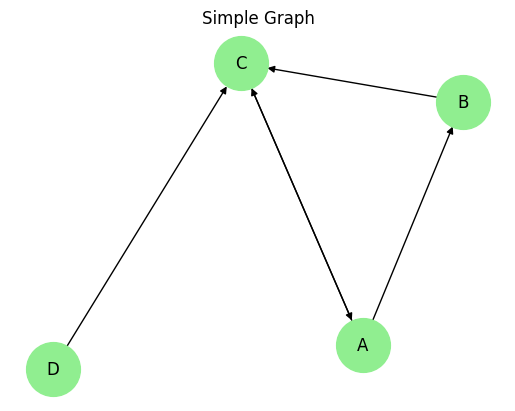

In [10]:
# The simple graph 
G_simple=adjacency_to_networkx(adj_simple,directed=True)
plt.title('Simple Graph')
nx.draw(G_simple,with_labels=True,node_size=1500,node_color='lightgreen')

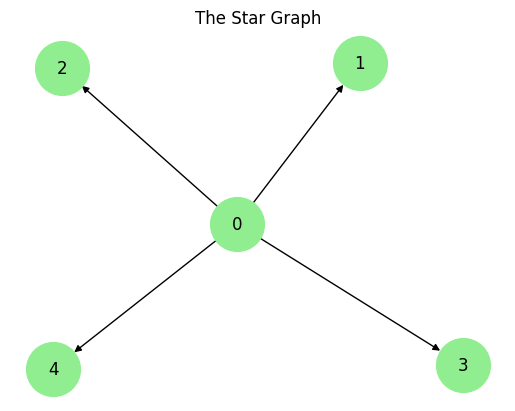

In [11]:
# The line graph 
G_star=adjacency_to_networkx(star_out,directed=True)
plt.title('The Star Graph')
nx.draw(G_star,with_labels=True,node_size=1500,node_color='lightgreen')

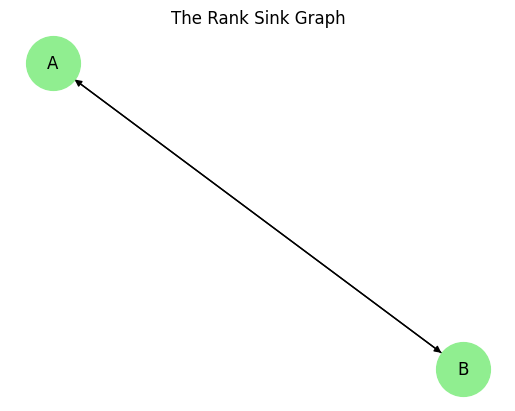

In [12]:
# The graph of rank sink 
G_sink=adjacency_to_networkx(rank_sink,directed=True)
plt.title('The Rank Sink Graph')
nx.draw(G_sink,with_labels=True,node_size=1500,node_color='lightgreen')

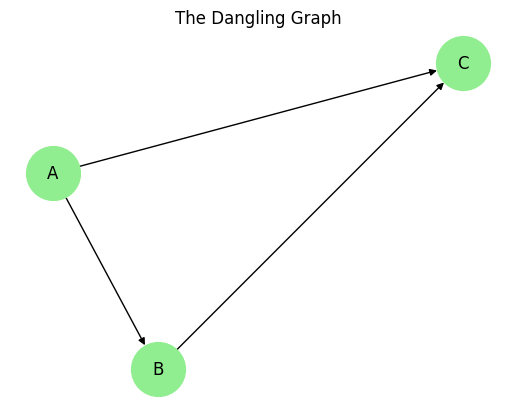

In [13]:
# The graph of dangling node 
G_dangling=adjacency_to_networkx(dangling_example,directed=True)
plt.title('The Dangling Graph')
nx.draw(G_dangling,with_labels=True,node_size=1500,node_color='lightgreen')

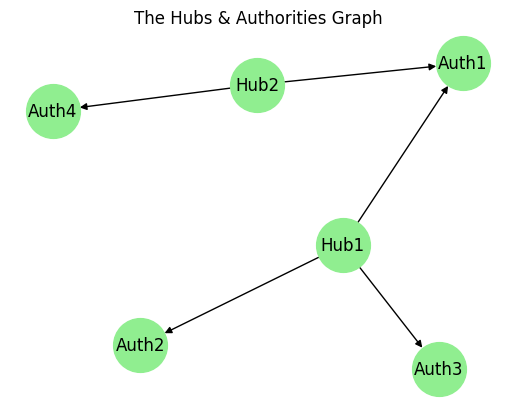

In [17]:
# The graph of hubs and authorities 
G_web=adjacency_to_networkx(web_structure,directed=True)
plt.title('The Hubs & Authorities Graph')
nx.draw(G_web,with_labels=True,node_size=1500,node_color='lightgreen')

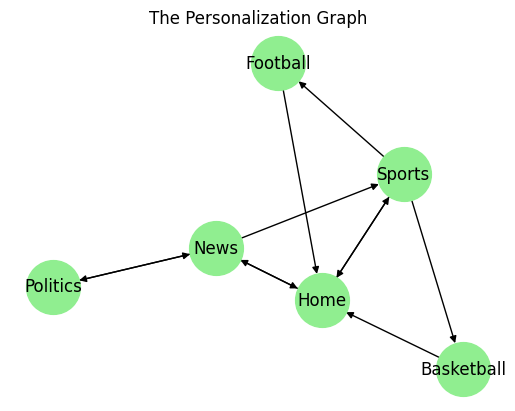

In [19]:
# The graph of personalization example 
G_web=adjacency_to_networkx(web_pages,directed=True)
plt.title('The Personalization Graph')
nx.draw(G_web,with_labels=True,node_size=1500,node_color='lightgreen')